In [9]:
import common_utils
from common_utils import *
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

setup_seed()
device = get_device()
print(f"Using device: {device}")

Using device: cuda


In [2]:
#!rm -rf ./fm_conditional_checkpoints

In [ ]:
# Load Labels and Mappings
label_path = 'EMOJI_FACE/labels.json'
categories, cat_to_idx, idx_to_cat, folder_to_cats = load_labels_and_mappings(labels_path=label_path)

print(f"Found {len(categories)} flattened categories:")
for i, cat in idx_to_cat.items():
    print(f"  {i}: {cat}")

# Initialize Data
data = load_conditional_dataset(root_dir="./EMOJI_FACE", folder_to_cats=folder_to_cats, num_categories=len(categories))
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)

# Show a sample
img, label_vec = next(iter(dataloader))
plt.figure(figsize=(4,4))
show_tensor_image(img[0])
active = (label_vec[0] > 0).nonzero(as_tuple=True)[0].tolist()
active_names = ", ".join(idx_to_cat[i] for i in active)
plt.title(f"Labels: {active_names}")
plt.show()

Found 8 flattened categories:
  0: emotion_fx
  1: eye_accessory
  2: eye_shape
  3: facial_hair_hat
  4: hands
  5: mouth_accessory
  6: mouth_shape
  7: skin_color


TypeError: load_conditional_dataset() got an unexpected keyword argument 'num_categories'

In [ ]:
model = ConditionalUnet(num_classes=len(categories))
print("Num params: ", sum(p.numel() for p in model.parameters()))
model.to(device)

## Loss Function

The loss function now takes `labels` and passes them to the model.

In [ ]:
def get_loss(model, x_1, t, labels_vec, device="cpu", cond_dropout=0.1):
    # Linear FM target
    x_0 = torch.randn_like(x_1)
    t_reshaped = t.view(-1, 1, 1, 1)
    x_t = (1 - t_reshaped) * x_0 + t_reshaped * x_1
    target_v = x_1 - x_0

    # Classifier-Free Guidance dropout: randomly drop labels to zeros
    if cond_dropout and cond_dropout > 0:
        drop_mask = (torch.rand(labels_vec.shape[0], device=device) < cond_dropout).float().view(-1, 1)
        labels_in = labels_vec.to(device) * (1.0 - drop_mask)
    else:
        labels_in = labels_vec.to(device)

    # Forward with multi-hot labels
    pred_v = model(x_t, t * 1000, labels_in)

    return F.mse_loss(pred_v, target_v)

## Sampling

We update the sampling function to accept a `class_label`.

In [ ]:
@torch.no_grad()
def build_label_vec_for_id(target_id, num_categories, folder_to_cats):
    # target_id can be int or str
    fid = str(target_id)
    vec = torch.zeros((1, num_categories), dtype=torch.float32, device=device)
    indices = folder_to_cats.get(fid, [])
    for ci in indices:
        if 0 <= ci < num_categories:
            vec[0, ci] = 1.0
    return vec

@torch.no_grad()
def sample_ode_euler_cfg(model, label_vec, steps=20, guidance_scale=3.0, device="cpu"):
    img_size = IMG_SIZE
    x = torch.randn((1, 3, img_size, img_size), device=device)
    dt = 1.0 / steps

    traj = [x.clone()]

    for i in range(steps):
        t_val = i / steps
        t = torch.full((1,), t_val, device=device, dtype=torch.float32)

        # Unconditional (zero labels) and conditional predictions
        v_uncond = model(x, t * 1000, torch.zeros_like(label_vec))
        v_cond = model(x, t * 1000, label_vec)
        v = v_uncond + guidance_scale * (v_cond - v_uncond)

        x = x + v * dt

        if i % (max(steps // 10, 1)) == 0:
            traj.append(x.clone())

    return x, traj

@torch.no_grad()
def sample_plot_conditional_by_id(target_id=None, steps=50, guidance_scale=3.0, save_path=None):
    # Pick random id if not provided
    if target_id is None:
        if len(folder_to_cats) == 0:
            raise ValueError("folder_to_cats is empty; ensure labels.json parsed correctly.")
        target_id = random.choice(list(folder_to_cats.keys()))
    fid = str(target_id)
    print(f"Generating sample for id: {fid}")

    label_vec = build_label_vec_for_id(fid, len(categories), folder_to_cats)

    plt.figure(figsize=(15, 3))
    plt.axis('off')

    final_img, traj = sample_ode_euler_cfg(model, label_vec, steps=steps, guidance_scale=guidance_scale, device=device)

    num_plots = 10
    step_size = max(len(traj) // num_plots, 1)

    for i in range(num_plots):
        idx = i * step_size
        if idx >= len(traj):
            break
        plt.subplot(1, num_plots + 1, i + 1)
        show_tensor_image(traj[idx].detach().cpu())

    plt.subplot(1, num_plots + 1, num_plots + 1)
    show_tensor_image(final_img.detach().cpu())
    plt.subplots_adjust(wspace=0.0, hspace=0)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

## Training Loop

In [ ]:
from torch.optim import AdamW
import time
import csv
import pandas as pd

optimizer = AdamW(model.parameters(), lr=2e-4)
epochs = 1400

checkpoint_dir = "fm_conditional_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
log_file = os.path.join(checkpoint_dir, "train_log.csv")
best_model_path = os.path.join(checkpoint_dir, "best_model.pt")

start_epoch = 0
best_loss = float("inf")

# Resume logic
if os.path.exists(log_file) and os.path.getsize(log_file) > 0:
    try:
        log_df = pd.read_csv(log_file)
        if not log_df.empty:
            last_epoch = log_df['epoch'].iloc[-1]
            start_epoch = int(last_epoch) + 1
            print(f"Resuming from epoch {start_epoch}")
    except:
        pass

if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_loss = checkpoint.get('loss', float('inf'))

if not os.path.exists(log_file):
    with open(log_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "avg_loss", "duration_sec"])

pending_rows = []
flush_every = 10

for epoch in range(start_epoch, epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.perf_counter()
    
    for step, (images, labels_vec) in enumerate(dataloader):
        optimizer.zero_grad()
        
        x_1 = images.to(device)
        labels_vec = labels_vec.to(device)
        
        current_batch_size = x_1.shape[0]
        t = torch.rand(current_batch_size, device=device)
        
        loss = get_loss(model, x_1, t, labels_vec, device=device, cond_dropout=0.1)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dataloader)
    duration = time.perf_counter() - start_time
    
    pending_rows.append([epoch, avg_epoch_loss, duration])

    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, best_model_path)
        print(f"New best model saved! Epoch:{epoch} Loss: {best_loss:.4f}")
        
        # Visualize progress
        model.eval()
        save_path = os.path.join(checkpoint_dir, f"epoch{epoch}_loss{best_loss:.4f}.png")
        sample_plot_conditional_by_id(steps=50, guidance_scale=3.0, save_path=save_path)

    if (len(pending_rows) >= flush_every) or (epoch == epochs - 1):
        with open(log_file, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(pending_rows)
        pending_rows.clear()

Resuming from epoch 40
Loading best model from fm_conditional_checkpoints/best_model.pt
New best model saved!Epoch:42 Loss: 0.2495
Generating sample for: emotion_neutral_skeptical
New best model saved!Epoch:42 Loss: 0.2495
Generating sample for: emotion_neutral_skeptical
New best model saved!Epoch:43 Loss: 0.2407
Generating sample for: emotion_sick_unwell
New best model saved!Epoch:43 Loss: 0.2407
Generating sample for: emotion_sick_unwell
New best model saved!Epoch:46 Loss: 0.2307
Generating sample for: emotion_fear_surprise
New best model saved!Epoch:46 Loss: 0.2307
Generating sample for: emotion_fear_surprise
New best model saved!Epoch:47 Loss: 0.2246
Generating sample for: emotion_angry
New best model saved!Epoch:47 Loss: 0.2246
Generating sample for: emotion_angry
New best model saved!Epoch:50 Loss: 0.2205
Generating sample for: feature_accessories_glasses_hats
New best model saved!Epoch:50 Loss: 0.2205
Generating sample for: feature_accessories_glasses_hats
New best model saved!E

KeyboardInterrupt: 

Generating sample for: emotion_angry


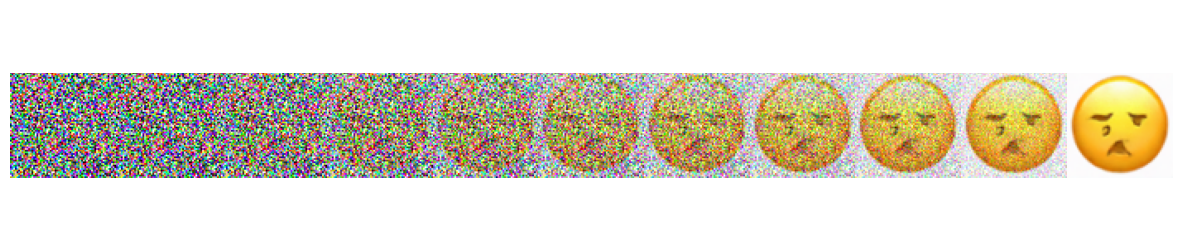

Generating sample for: emotion_fear_surprise


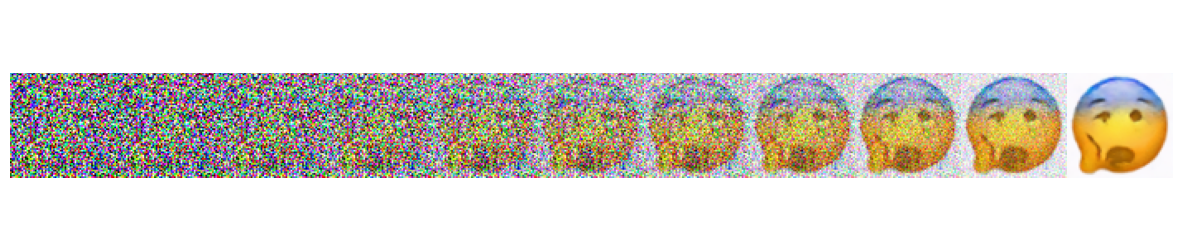

Generating sample for: emotion_happy_joy


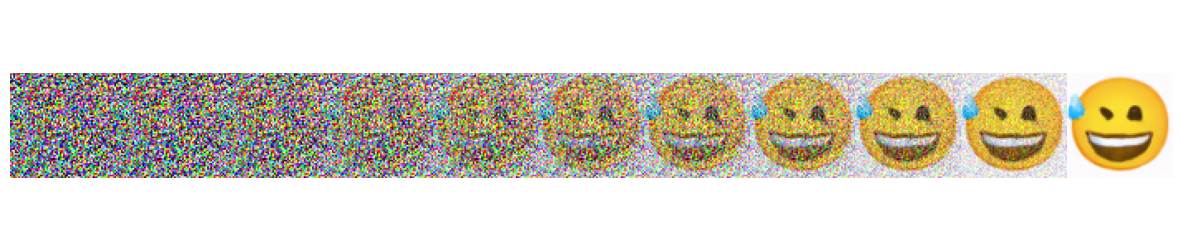

Generating sample for: emotion_love_affection


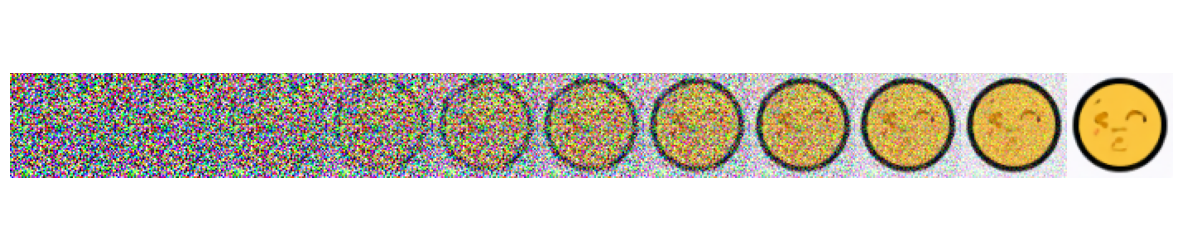

Generating sample for: emotion_neutral_skeptical


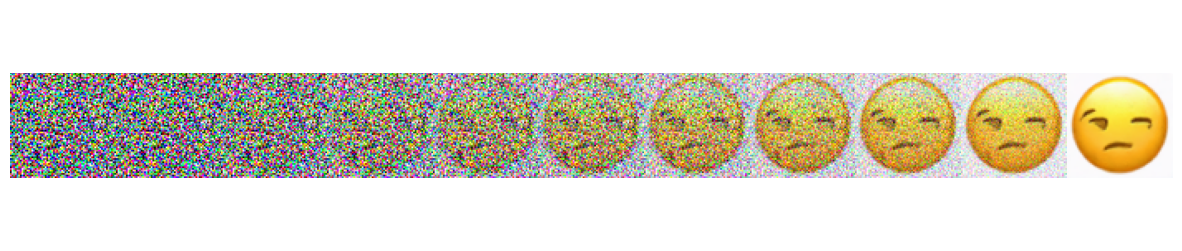

Generating sample for: emotion_playful_silly


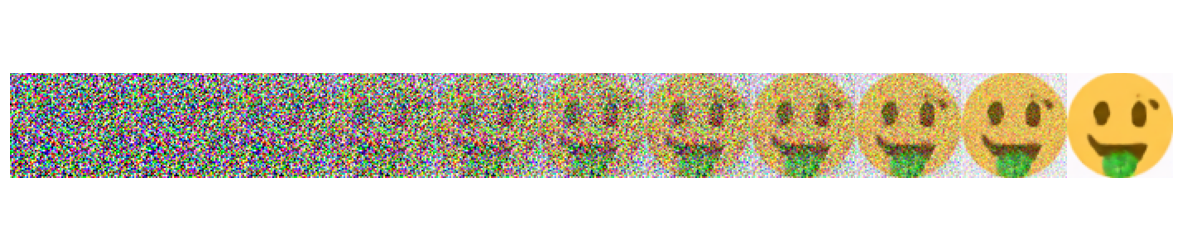

Generating sample for: emotion_sad_disappointed


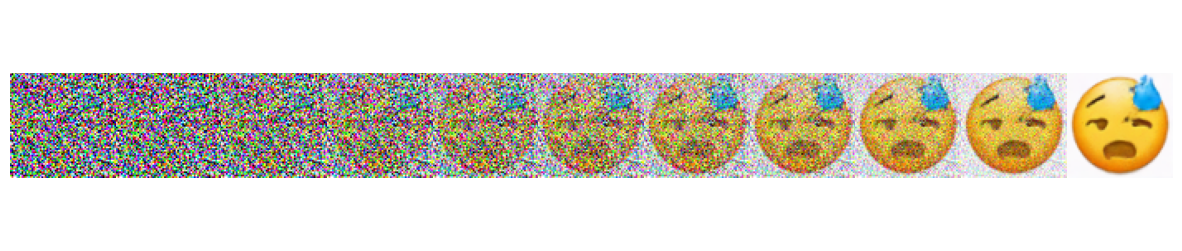

Generating sample for: emotion_sick_unwell


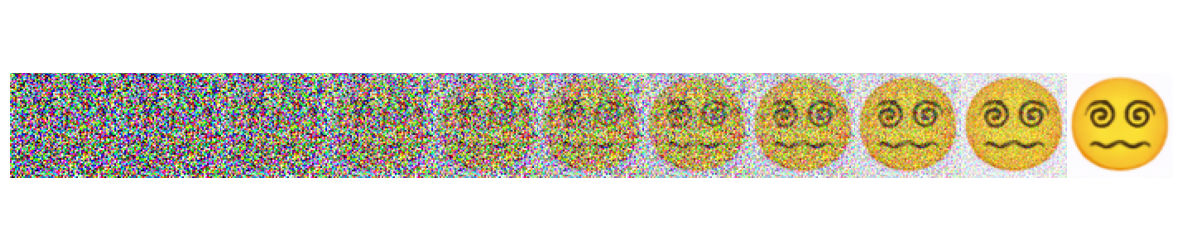

Generating sample for: emotion_sleepy_tired


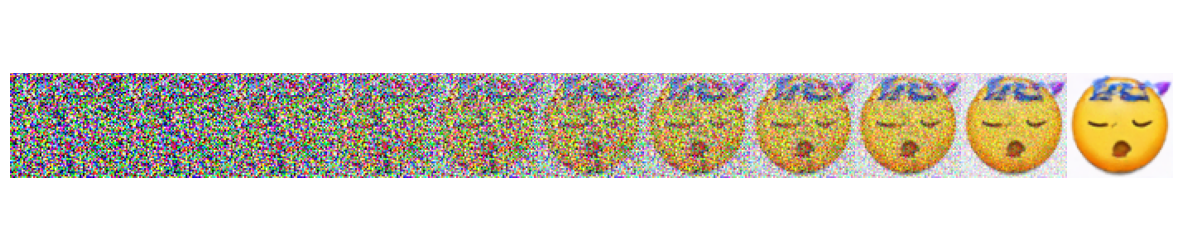

Generating sample for: feature_accessories_glasses_hats


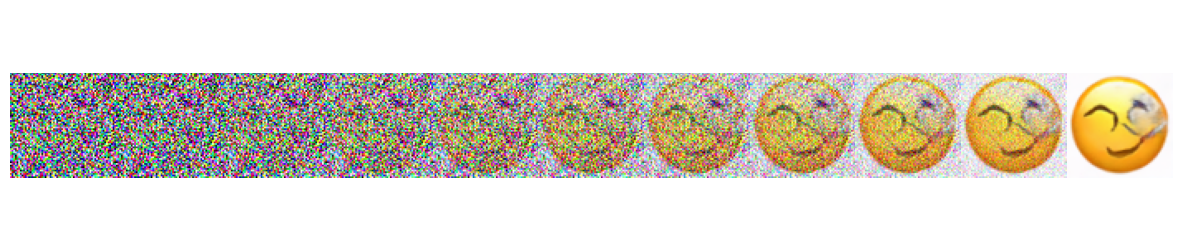

Generating sample for: feature_glasses


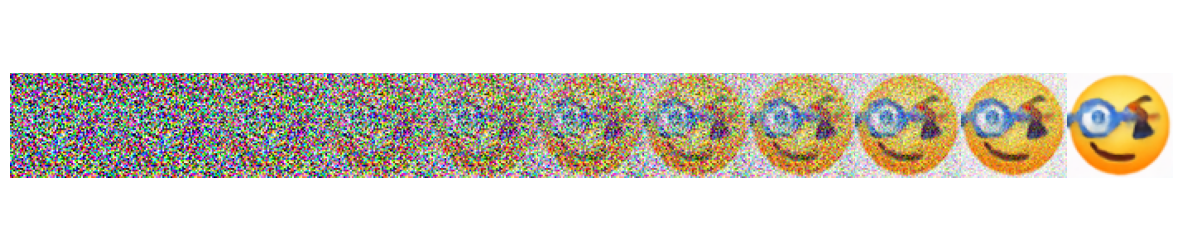

Generating sample for: feature_hand_gesture


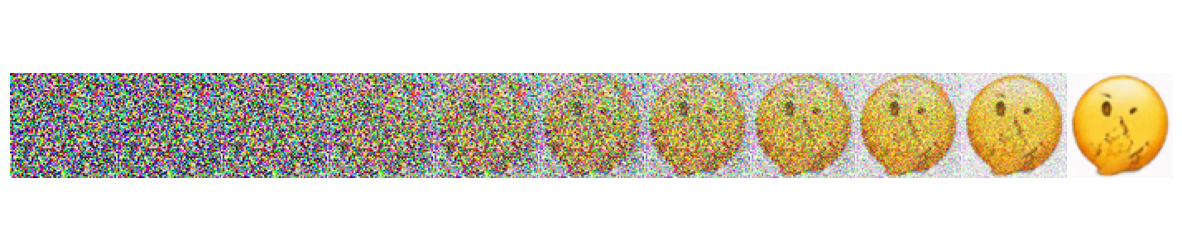

Generating sample for: feature_hats


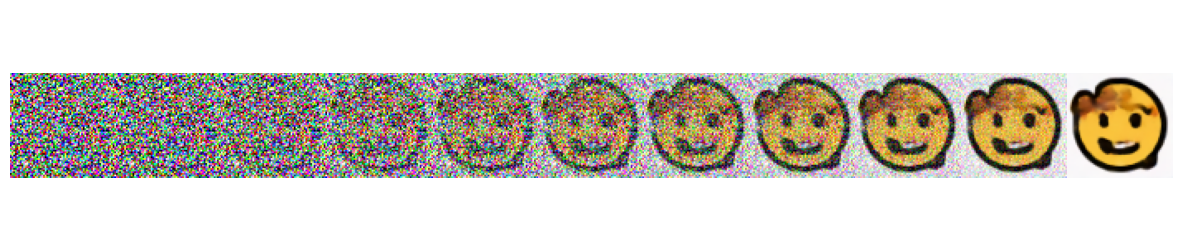

Generating sample for: feature_medical_covers


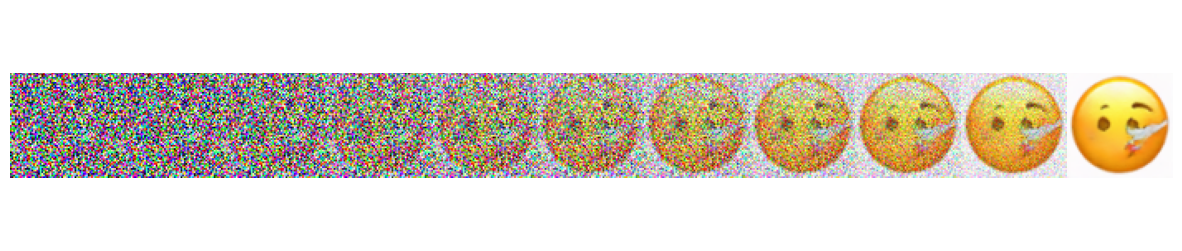

Generating sample for: feature_tears_sweat


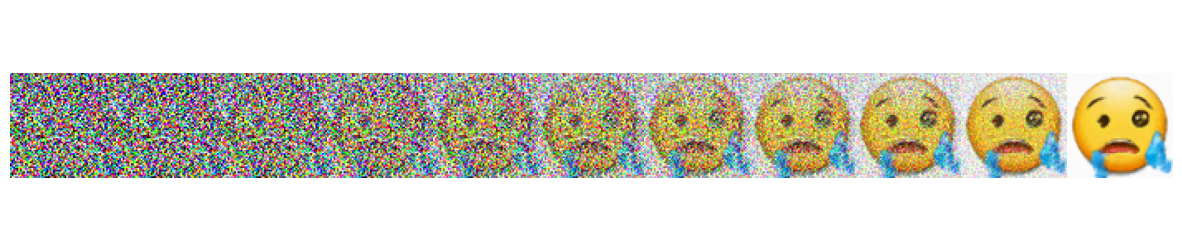

Generating sample for: feature_tongue_out


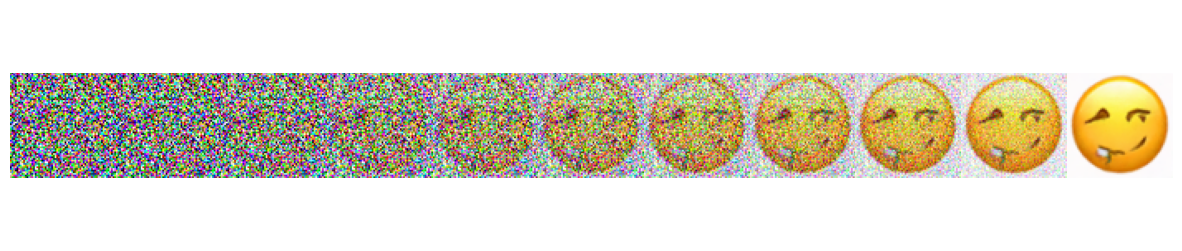

In [ ]:
# Generate samples for a few ids
model.eval()
example_ids = list(folder_to_cats.keys())[:5]
for fid in example_ids:
    sample_plot_conditional_by_id(fid, steps=50, guidance_scale=3.0)